In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive/train_kobert')

In [3]:
from google.colab import output
!pip install -r requirements.txt
output.clear()

### numpy가 엣날 버전이라 런타임 재실행하라고 뜨는데 그냥 ㅇㅇ 누르고 바로 아레 셀 부터 하면 됌

In [1]:
import os
os.chdir('/content/drive/MyDrive/train_kobert')

In [2]:
from kobertt import BERTDataset,BERTClassifier,BERTSentenceTransform

In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/polarity.csv')

In [37]:
df = pd.read_csv('train_set.csv')

In [5]:
df['polarity'].value_counts()

,count
polarity,
긍정,2603
부정,1176
중립,227


In [39]:
! python run_train.py \
    --train_path='train_set.csv' \
    --max_len=64 \
    --batch_size=32 \
    --warmup_ratio=0.1 \
    --num_epochs=10 \
    --max_grad_norm=1 \
    --log_interval=200 \
    --learning_rate=5e-5 \
    --device=cuda

/content/drive/MyDrive/train_kobert/run_train.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('중립',int(2))
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/tra

In [13]:
max_len=64
batch_size=32
warmup_ratio=0.1
num_epochs=5
max_grad_norm=1
log_interval=200
learning_rate=5e-5

In [12]:
from kobertt import BERTDataset,BERTClassifier,BERTSentenceTransform
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import gluonnlp as nlp


In [14]:
device = torch.device("cuda:0")

In [97]:
def predict(test_df:pd.DataFrame):

  tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
  bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
  vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
  device = torch.device("cuda:0")

  model = torch.load('capstone.model')

  d = test_df['Detail']
  for predict_sentence in d:
    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()
    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model (token_ids, valid_length, segment_ids)

        for i in out:
          logits=i
          logits = logits.detach().cpu().numpy()

          if np.argmax(logits) == 0:
            print(predict_sentence, '부정')
          if np.argmax(logits) == 1:
            print(predict_sentence, '긍정')
          if np.argmax(logits) == 2:
            print(predict_sentence, '중립')



In [100]:
predict(df)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-97-0aa59fa853e9>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytor

'뚜껑이 닫히지 않아 애를 먹었습니다. 뚜껑을 편하게 닫을 수 있도록 개선 했으면 더 좋겠습니다.' 중립
'시골에서 닭한마리삶으려면 불때서해먹어야 푹 고아지는데 설정시간보다 좀  길게 삶으니까' 부정
'사용하기 편리하고요. 좋아요 단지 처음 사용할때 증기 나오는 곳을 막는 걸 몰라서 안막는 실수가 있었을뿐.' 긍정
'용량은 적당한 양으로는 잘 되요 너무 많은 양은 안되니 적절히 사용하면 되네요.' 중립
'밥을하고 조금지나 보온으로 넘어가는데 밥이 누룽지가생기고 눌러붙네요 내솥이 스텐레스 특성상 눌러붙는다는데  아쉽네요' 부정
'딸랑구 기숙사 들어가서 구입했는데  너무 귀엽고 앙증맞네요~' 긍정
'2년동안 고장 안나고 잘 썼으면 좋겠네요~' 중립
'쌀 불리고 뜸 들이고 넉넉하게 1시간 긍정
색깔 모두 대만족!' 긍정
크기 부정


TypeError: 'float' object is not iterable

In [ ]:
 test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:

            if np.argmax(logits) == 1:

            if np.argmax(logits) == 2:

In [41]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/train_kobert/expanded_reviews_with_categories.xlsx')

In [42]:
df['Detail']

,Detail
0,'뚜껑이 닫히지 않아 애를 먹었습니다. 뚜껑을 편하게 닫을 수 있도록 개선 했으면 ...
1,'시골에서 닭한마리삶으려면 불때서해먹어야 푹 고아지는데 설정시간보다 좀 길게 삶으니까'
2,'사용하기 편리하고요. 좋아요 단지 처음 사용할때 증기 나오는 곳을 막는 걸 몰라서...
3,'용량은 적당한 양으로는 잘 되요 너무 많은 양은 안되니 적절히 사용하면 되네요.'
4,'밥을하고 조금지나 보온으로 넘어가는데 밥이 누룽지가생기고 눌러붙네요 내솥이 스텐레...
...,...
92,디자인도 마음에 듭니다.'
93,가격은 두말할것도 없이 넘 만족스러운 제품이네요 오히려 가격이 넘 싸서 정품이 맞는...
94,왜케 화력이 센지...감동입니다'
95,디자인도 깔끔해요^^만족스럽네요'


In [45]:
a = predict(df['Detail'][2])
a

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
<ipython-input-40-e5972bcb10bd>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

tensor([[-1.7569,  1.3555,  0.9208]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [46]:
for i in df['Detail']:
  print(i)

'뚜껑이 닫히지 않아 애를 먹었습니다. 뚜껑을 편하게 닫을 수 있도록 개선 했으면 더 좋겠습니다.'
'시골에서 닭한마리삶으려면 불때서해먹어야 푹 고아지는데 설정시간보다 좀  길게 삶으니까'
'사용하기 편리하고요. 좋아요 단지 처음 사용할때 증기 나오는 곳을 막는 걸 몰라서 안막는 실수가 있었을뿐.'
'용량은 적당한 양으로는 잘 되요 너무 많은 양은 안되니 적절히 사용하면 되네요.'
'밥을하고 조금지나 보온으로 넘어가는데 밥이 누룽지가생기고 눌러붙네요 내솥이 스텐레스 특성상 눌러붙는다는데  아쉽네요'
'딸랑구 기숙사 들어가서 구입했는데  너무 귀엽고 앙증맞네요~'
'2년동안 고장 안나고 잘 썼으면 좋겠네요~'
'쌀 불리고 뜸 들이고 넉넉하게 1시간
색깔 모두 대만족!'
크기
nan
nan
밥맛도 제법 괜찮아요.'
쓰던밥솥이 오래되서  그런지 아랫부분은잘되는데 위에는 밥이 설익어요 밥도잘안되고 맛이 없어요'
블랙 색상이 고급스럽네요.'
저렴한데 밥맛도 최고에요!!'
'가격 할인에  쿠폰 할인 까지 정말 감사합니다'
색상이 깔끔하고 넘 예뻐요 ㅎㅎ '
하얀색상이 예뻐요'
밥도잘되고 기능도 복잡하지 않으며'
주말 특가로 다른 사이트보다 값싸게 구매했어요'
'잡곡밥 했는데 누룽지도 많이눌지않고  찰지게 잘되네요.''
'역시○○○가 디자인ㆍ성능ㆍ가성비등 저에게는 맞습니다.'''
디자인이 정말 고급스러워 보여요~ 고품격 디자인~♡'
착하고 좋은 가격에  구매해서 좋아요ᆞᆢ'
사용 해 보니 잘 안갈린다고 하네요ᆞᆢ 어찌 된건 가요 ?      '
매일 원두갈고 직접 내려 마시는 것이 좋았는데
nan
조작도 편해요^^'
뚜껑이 고정이 안돼고 누르면 분쇄가 되네요~~~'
사이즈도 좀 큰편이라 보관이 좀.....'
'가격대비  그냥 쓸만 한것 같아요.'
'색감이 고급스러워서 마음에 들고
nan
'기존에 쓰던 가스레인지 보다 성능이 좀 더 좋은것 같아 좋습니다^^'
'원터치 점화가 엄청 편합니다.'
'가격대비 저렴하게 구매했습니다 감사해요'
'점화는 물론이고 화력도 쎄서 완전 만족

In [78]:
train_acc = []
test_acc = []
loss = []

with open('/content/drive/MyDrive/train_kobert/capstone_run-2024-11-09 06:23:01.004964.log','r') as f:
  lines = f.readlines()

  for i in range(len(lines)):
    if 'train acc' in lines[i].split(':')[-1]:
      if 'batch' in lines[i].split(':')[-1]:
        loss.append(lines[i].split(':')[-1].split(' ')[7])
        train_acc.append(lines[i].split(':')[-1].split(' ')[-1])
    else:
      test_acc.append(lines[i].split(':')[-1].split(' ')[-1])


In [81]:
for i in range(len(train_acc)):
  train_acc[i] = train_acc[i].replace('\n','')
for i in range(len(test_acc)):
  test_acc[i] = test_acc[i].replace('\n','')

In [82]:
test_acc

['0.9119543650793651',
 '0.9210813492063491',
 '0.9254960317460318',
 '0.9372271825396825',
 '0.9296626984126984',
 '0.9283730158730158',
 '0.9387896825396825',
 '0.9393105158730158',
 '0.9419146825396825',
 '0.9419146825396825']

In [83]:
train_acc = np.array(train_acc).astype(float)
test_acc = np.array(test_acc).astype(float)
loss = np.array(loss).astype(float)

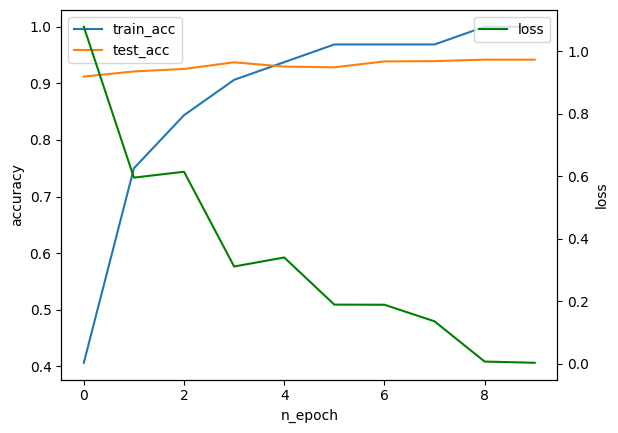

In [96]:
import matplotlib.pyplot as plt

x = np.arange(len(train_acc))

fig, ax1 = plt.subplots()
ax1.plot(x, train_acc)
ax1.plot(x,test_acc)
ax1.set_ylabel('accuracy')
ax1.set_xlabel('n_epoch')
ax1.legend(['train_acc','test_acc'])

ax2 = ax1.twinx()
ax2.plot(x,loss,color='g')
ax2.set_ylabel('loss')
ax2.legend(['loss'])
plt.show()